# VGG

This notebook uses model "VGG16" to conduct regression of images.

In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [ ]:
# Dataset and model path
DATASET_PATH = "/home/ubuntu/Desktop/Ra/datasets/Ra_128_indexed_decimal_1.h5"
MODEL_PATH = "/home/ubuntu/Desktop/Ra/models/VGG16_128_regression_decimal_1.pth"
OUTPUT_PATH = "/home/ubuntu/Desktop/Ra/outputs/VGG16_128_regression_decimal_1.csv"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
NUM_EPOCHS = 200
LR = 1e-4
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 10

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Path
if not os.path.exists(os.path.dirname(MODEL_PATH)):
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    print(f"Make new directory {os.path.dirname(MODEL_PATH)}")

Device: cuda


Then load the pretrained model from `torchvision`.

In [3]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
for param in vgg16.features.parameters():
    param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images, and normalize the pixel values.

In [4]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

# Image standardization
mean = images.mean(dim=[0, 2, 3], keepdim=True)
std = images.std(dim=[0, 2, 3], keepdim=True)
images = (images - mean) / std

# Label normalization
labels = (labels - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)



Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9182, 128, 128, 3)
Labels Shape: (9182,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9182, 3, 128, 128])
Labels Shape: torch.Size([9182])


Then use `train_test_split` function to get data for training and validation.

In [5]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)
print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Train test split with test size 0.2.
Images (train) Shape: torch.Size([7345, 3, 128, 128])
Images (val) Shape: torch.Size([1837, 3, 128, 128])
Labels (train) Shape: torch.Size([7345])
Labels (val) Shape: torch.Size([1837])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [6]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/tmp/ipykernel_2447/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([7345, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([7345, 1])
Shape of `images_val_tensor`: torch.Size([1837, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([1837, 1])


/tmp/ipykernel_2447/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
/tmp/ipykernel_2447/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_2447/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Train

Start training for `epoch` loops, record the training losses and validation losses.

In [7]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    vgg16.classifier.parameters(), lr=LR, weight_decay=LR_WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Record the loss values
train_loss_list = []
val_loss_list = []

# Loop by epoch
for epoch in range(NUM_EPOCHS):

    # Train
    vgg16.train()
    train_loss = 0.0
    train_size = 0
    for batch_images, batch_labels in train_loader:
        # Load data
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # Pass loss value
        outputs = vgg16(batch_images)
        loss = criterion(outputs, batch_labels)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add to the total loss
        batch_size = batch_images.size(0)
        train_loss += loss.item() * batch_size
        train_size += batch_size

    train_loss = train_loss / train_size
    train_loss_list.append(train_loss)

    # Validate
    vgg16.eval()
    val_loss = 0
    val_samples = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Load data
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # Output
            outputs = vgg16(batch_images)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
            # Add to total loss
            batch_size = batch_images.size(0)
            val_loss += loss.item() * batch_size
            val_samples += batch_size
    val_loss /= val_samples
    val_loss_list.append(val_loss)

    # Print
    print(
        f"[Epoch {(epoch+1):d} / {(NUM_EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {val_loss:f} (MSE)] [Learning Rate: {optimizer.param_groups[0]['lr']}]"
    )

    # Scheduler
    scheduler.step(val_loss)

[Epoch 1 / 200] [Train Loss 0.085384 (MSE)] [Valid Loss 0.041888 (MSE)] [Learning Rate: 0.0001]


[Epoch 2 / 200] [Train Loss 0.023248 (MSE)] [Valid Loss 0.023120 (MSE)] [Learning Rate: 0.0001]


[Epoch 3 / 200] [Train Loss 0.016962 (MSE)] [Valid Loss 0.015897 (MSE)] [Learning Rate: 0.0001]


[Epoch 4 / 200] [Train Loss 0.013105 (MSE)] [Valid Loss 0.013504 (MSE)] [Learning Rate: 0.0001]


[Epoch 5 / 200] [Train Loss 0.011483 (MSE)] [Valid Loss 0.011453 (MSE)] [Learning Rate: 0.0001]


[Epoch 6 / 200] [Train Loss 0.009283 (MSE)] [Valid Loss 0.010821 (MSE)] [Learning Rate: 0.0001]


[Epoch 7 / 200] [Train Loss 0.008406 (MSE)] [Valid Loss 0.017813 (MSE)] [Learning Rate: 0.0001]


[Epoch 8 / 200] [Train Loss 0.007993 (MSE)] [Valid Loss 0.009798 (MSE)] [Learning Rate: 0.0001]


[Epoch 9 / 200] [Train Loss 0.007178 (MSE)] [Valid Loss 0.009401 (MSE)] [Learning Rate: 0.0001]


[Epoch 10 / 200] [Train Loss 0.006389 (MSE)] [Valid Loss 0.007557 (MSE)] [Learning Rate: 0.0001]


[Epoch 11 / 200] [Train Loss 0.005991 (MSE)] [Valid Loss 0.008582 (MSE)] [Learning Rate: 0.0001]


[Epoch 12 / 200] [Train Loss 0.005613 (MSE)] [Valid Loss 0.008079 (MSE)] [Learning Rate: 0.0001]


[Epoch 13 / 200] [Train Loss 0.005701 (MSE)] [Valid Loss 0.008368 (MSE)] [Learning Rate: 0.0001]


[Epoch 14 / 200] [Train Loss 0.005490 (MSE)] [Valid Loss 0.007458 (MSE)] [Learning Rate: 0.0001]


[Epoch 15 / 200] [Train Loss 0.005238 (MSE)] [Valid Loss 0.017827 (MSE)] [Learning Rate: 0.0001]


[Epoch 16 / 200] [Train Loss 0.005318 (MSE)] [Valid Loss 0.008743 (MSE)] [Learning Rate: 0.0001]


[Epoch 17 / 200] [Train Loss 0.004850 (MSE)] [Valid Loss 0.007959 (MSE)] [Learning Rate: 0.0001]


[Epoch 18 / 200] [Train Loss 0.004937 (MSE)] [Valid Loss 0.007090 (MSE)] [Learning Rate: 0.0001]


[Epoch 19 / 200] [Train Loss 0.004867 (MSE)] [Valid Loss 0.004483 (MSE)] [Learning Rate: 0.0001]


[Epoch 20 / 200] [Train Loss 0.004336 (MSE)] [Valid Loss 0.008421 (MSE)] [Learning Rate: 0.0001]


[Epoch 21 / 200] [Train Loss 0.004409 (MSE)] [Valid Loss 0.008239 (MSE)] [Learning Rate: 0.0001]


[Epoch 22 / 200] [Train Loss 0.004738 (MSE)] [Valid Loss 0.009413 (MSE)] [Learning Rate: 0.0001]


[Epoch 23 / 200] [Train Loss 0.004529 (MSE)] [Valid Loss 0.008784 (MSE)] [Learning Rate: 0.0001]


[Epoch 24 / 200] [Train Loss 0.004256 (MSE)] [Valid Loss 0.006138 (MSE)] [Learning Rate: 0.0001]


[Epoch 25 / 200] [Train Loss 0.004106 (MSE)] [Valid Loss 0.004799 (MSE)] [Learning Rate: 0.0001]


[Epoch 26 / 200] [Train Loss 0.003481 (MSE)] [Valid Loss 0.007634 (MSE)] [Learning Rate: 5e-05]


[Epoch 27 / 200] [Train Loss 0.003199 (MSE)] [Valid Loss 0.006476 (MSE)] [Learning Rate: 5e-05]


[Epoch 28 / 200] [Train Loss 0.002790 (MSE)] [Valid Loss 0.006966 (MSE)] [Learning Rate: 5e-05]


[Epoch 29 / 200] [Train Loss 0.002775 (MSE)] [Valid Loss 0.008604 (MSE)] [Learning Rate: 5e-05]


[Epoch 30 / 200] [Train Loss 0.002549 (MSE)] [Valid Loss 0.006949 (MSE)] [Learning Rate: 5e-05]


[Epoch 31 / 200] [Train Loss 0.002643 (MSE)] [Valid Loss 0.009408 (MSE)] [Learning Rate: 5e-05]


[Epoch 32 / 200] [Train Loss 0.002350 (MSE)] [Valid Loss 0.006595 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 33 / 200] [Train Loss 0.002117 (MSE)] [Valid Loss 0.007737 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 34 / 200] [Train Loss 0.002042 (MSE)] [Valid Loss 0.005988 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 35 / 200] [Train Loss 0.002107 (MSE)] [Valid Loss 0.005914 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 36 / 200] [Train Loss 0.001954 (MSE)] [Valid Loss 0.006214 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 37 / 200] [Train Loss 0.001961 (MSE)] [Valid Loss 0.007182 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 38 / 200] [Train Loss 0.001741 (MSE)] [Valid Loss 0.006573 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 39 / 200] [Train Loss 0.001665 (MSE)] [Valid Loss 0.006311 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 40 / 200] [Train Loss 0.001670 (MSE)] [Valid Loss 0.007486 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 41 / 200] [Train Loss 0.001582 (MSE)] [Valid Loss 0.006646 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 42 / 200] [Train Loss 0.001602 (MSE)] [Valid Loss 0.006283 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 43 / 200] [Train Loss 0.001589 (MSE)] [Valid Loss 0.007516 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 44 / 200] [Train Loss 0.001518 (MSE)] [Valid Loss 0.008192 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 45 / 200] [Train Loss 0.001427 (MSE)] [Valid Loss 0.007537 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 46 / 200] [Train Loss 0.001402 (MSE)] [Valid Loss 0.006956 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 47 / 200] [Train Loss 0.001473 (MSE)] [Valid Loss 0.007504 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 48 / 200] [Train Loss 0.001376 (MSE)] [Valid Loss 0.007035 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 49 / 200] [Train Loss 0.001372 (MSE)] [Valid Loss 0.006841 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 50 / 200] [Train Loss 0.001359 (MSE)] [Valid Loss 0.007069 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 51 / 200] [Train Loss 0.001333 (MSE)] [Valid Loss 0.007617 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 52 / 200] [Train Loss 0.001351 (MSE)] [Valid Loss 0.007598 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 53 / 200] [Train Loss 0.001334 (MSE)] [Valid Loss 0.006877 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 54 / 200] [Train Loss 0.001304 (MSE)] [Valid Loss 0.007131 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 55 / 200] [Train Loss 0.001252 (MSE)] [Valid Loss 0.007132 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 56 / 200] [Train Loss 0.001257 (MSE)] [Valid Loss 0.007677 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 57 / 200] [Train Loss 0.001243 (MSE)] [Valid Loss 0.006951 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 58 / 200] [Train Loss 0.001265 (MSE)] [Valid Loss 0.007454 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 59 / 200] [Train Loss 0.001255 (MSE)] [Valid Loss 0.007304 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 60 / 200] [Train Loss 0.001196 (MSE)] [Valid Loss 0.006847 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 61 / 200] [Train Loss 0.001211 (MSE)] [Valid Loss 0.007185 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 62 / 200] [Train Loss 0.001159 (MSE)] [Valid Loss 0.007307 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 63 / 200] [Train Loss 0.001198 (MSE)] [Valid Loss 0.007155 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 64 / 200] [Train Loss 0.001228 (MSE)] [Valid Loss 0.007114 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 65 / 200] [Train Loss 0.001212 (MSE)] [Valid Loss 0.007279 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 66 / 200] [Train Loss 0.001240 (MSE)] [Valid Loss 0.007309 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 67 / 200] [Train Loss 0.001216 (MSE)] [Valid Loss 0.007140 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 68 / 200] [Train Loss 0.001170 (MSE)] [Valid Loss 0.007329 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 69 / 200] [Train Loss 0.001184 (MSE)] [Valid Loss 0.007083 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 70 / 200] [Train Loss 0.001208 (MSE)] [Valid Loss 0.007120 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 71 / 200] [Train Loss 0.001155 (MSE)] [Valid Loss 0.007241 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 72 / 200] [Train Loss 0.001186 (MSE)] [Valid Loss 0.007271 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 73 / 200] [Train Loss 0.001183 (MSE)] [Valid Loss 0.007079 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 74 / 200] [Train Loss 0.001153 (MSE)] [Valid Loss 0.007152 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 75 / 200] [Train Loss 0.001153 (MSE)] [Valid Loss 0.007120 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 76 / 200] [Train Loss 0.001172 (MSE)] [Valid Loss 0.007124 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 77 / 200] [Train Loss 0.001132 (MSE)] [Valid Loss 0.007193 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 78 / 200] [Train Loss 0.001182 (MSE)] [Valid Loss 0.007330 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 79 / 200] [Train Loss 0.001148 (MSE)] [Valid Loss 0.007016 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 80 / 200] [Train Loss 0.001167 (MSE)] [Valid Loss 0.007202 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 81 / 200] [Train Loss 0.001195 (MSE)] [Valid Loss 0.007194 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 82 / 200] [Train Loss 0.001178 (MSE)] [Valid Loss 0.007243 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 83 / 200] [Train Loss 0.001176 (MSE)] [Valid Loss 0.007133 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 84 / 200] [Train Loss 0.001163 (MSE)] [Valid Loss 0.007306 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 85 / 200] [Train Loss 0.001167 (MSE)] [Valid Loss 0.007203 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 86 / 200] [Train Loss 0.001162 (MSE)] [Valid Loss 0.007216 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 87 / 200] [Train Loss 0.001221 (MSE)] [Valid Loss 0.007215 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 88 / 200] [Train Loss 0.001139 (MSE)] [Valid Loss 0.007188 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 89 / 200] [Train Loss 0.001179 (MSE)] [Valid Loss 0.007169 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 90 / 200] [Train Loss 0.001211 (MSE)] [Valid Loss 0.007233 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 91 / 200] [Train Loss 0.001224 (MSE)] [Valid Loss 0.007224 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 92 / 200] [Train Loss 0.001177 (MSE)] [Valid Loss 0.007206 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 93 / 200] [Train Loss 0.001159 (MSE)] [Valid Loss 0.007209 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 94 / 200] [Train Loss 0.001169 (MSE)] [Valid Loss 0.007201 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 95 / 200] [Train Loss 0.001140 (MSE)] [Valid Loss 0.007182 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 96 / 200] [Train Loss 0.001169 (MSE)] [Valid Loss 0.007203 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 97 / 200] [Train Loss 0.001141 (MSE)] [Valid Loss 0.007214 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 98 / 200] [Train Loss 0.001171 (MSE)] [Valid Loss 0.007211 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 99 / 200] [Train Loss 0.001213 (MSE)] [Valid Loss 0.007198 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 100 / 200] [Train Loss 0.001168 (MSE)] [Valid Loss 0.007216 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 101 / 200] [Train Loss 0.001181 (MSE)] [Valid Loss 0.007225 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 102 / 200] [Train Loss 0.001151 (MSE)] [Valid Loss 0.007239 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 103 / 200] [Train Loss 0.001156 (MSE)] [Valid Loss 0.007229 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 104 / 200] [Train Loss 0.001169 (MSE)] [Valid Loss 0.007230 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 105 / 200] [Train Loss 0.001156 (MSE)] [Valid Loss 0.007212 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 106 / 200] [Train Loss 0.001212 (MSE)] [Valid Loss 0.007208 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 107 / 200] [Train Loss 0.001139 (MSE)] [Valid Loss 0.007211 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 108 / 200] [Train Loss 0.001143 (MSE)] [Valid Loss 0.007209 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 109 / 200] [Train Loss 0.001177 (MSE)] [Valid Loss 0.007200 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 110 / 200] [Train Loss 0.001199 (MSE)] [Valid Loss 0.007184 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 111 / 200] [Train Loss 0.001182 (MSE)] [Valid Loss 0.007201 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 112 / 200] [Train Loss 0.001137 (MSE)] [Valid Loss 0.007192 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 113 / 200] [Train Loss 0.001171 (MSE)] [Valid Loss 0.007202 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 114 / 200] [Train Loss 0.001203 (MSE)] [Valid Loss 0.007197 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 115 / 200] [Train Loss 0.001157 (MSE)] [Valid Loss 0.007200 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 116 / 200] [Train Loss 0.001180 (MSE)] [Valid Loss 0.007186 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 117 / 200] [Train Loss 0.001154 (MSE)] [Valid Loss 0.007203 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 118 / 200] [Train Loss 0.001155 (MSE)] [Valid Loss 0.007228 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 119 / 200] [Train Loss 0.001140 (MSE)] [Valid Loss 0.007205 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 120 / 200] [Train Loss 0.001145 (MSE)] [Valid Loss 0.007205 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 121 / 200] [Train Loss 0.001130 (MSE)] [Valid Loss 0.007193 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 122 / 200] [Train Loss 0.001151 (MSE)] [Valid Loss 0.007195 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 123 / 200] [Train Loss 0.001157 (MSE)] [Valid Loss 0.007204 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 124 / 200] [Train Loss 0.001188 (MSE)] [Valid Loss 0.007197 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 125 / 200] [Train Loss 0.001188 (MSE)] [Valid Loss 0.007194 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 126 / 200] [Train Loss 0.001181 (MSE)] [Valid Loss 0.007198 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 127 / 200] [Train Loss 0.001135 (MSE)] [Valid Loss 0.007198 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 128 / 200] [Train Loss 0.001161 (MSE)] [Valid Loss 0.007225 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 129 / 200] [Train Loss 0.001141 (MSE)] [Valid Loss 0.007210 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 130 / 200] [Train Loss 0.001149 (MSE)] [Valid Loss 0.007218 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 131 / 200] [Train Loss 0.001154 (MSE)] [Valid Loss 0.007205 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 132 / 200] [Train Loss 0.001194 (MSE)] [Valid Loss 0.007223 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 133 / 200] [Train Loss 0.001202 (MSE)] [Valid Loss 0.007216 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 134 / 200] [Train Loss 0.001191 (MSE)] [Valid Loss 0.007206 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 135 / 200] [Train Loss 0.001202 (MSE)] [Valid Loss 0.007185 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 136 / 200] [Train Loss 0.001147 (MSE)] [Valid Loss 0.007196 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 137 / 200] [Train Loss 0.001175 (MSE)] [Valid Loss 0.007192 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 138 / 200] [Train Loss 0.001166 (MSE)] [Valid Loss 0.007197 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 139 / 200] [Train Loss 0.001171 (MSE)] [Valid Loss 0.007201 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 140 / 200] [Train Loss 0.001168 (MSE)] [Valid Loss 0.007196 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 141 / 200] [Train Loss 0.001173 (MSE)] [Valid Loss 0.007209 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 142 / 200] [Train Loss 0.001180 (MSE)] [Valid Loss 0.007222 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 143 / 200] [Train Loss 0.001170 (MSE)] [Valid Loss 0.007221 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 144 / 200] [Train Loss 0.001151 (MSE)] [Valid Loss 0.007223 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 145 / 200] [Train Loss 0.001185 (MSE)] [Valid Loss 0.007202 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 146 / 200] [Train Loss 0.001159 (MSE)] [Valid Loss 0.007195 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 147 / 200] [Train Loss 0.001124 (MSE)] [Valid Loss 0.007189 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 148 / 200] [Train Loss 0.001167 (MSE)] [Valid Loss 0.007209 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 149 / 200] [Train Loss 0.001208 (MSE)] [Valid Loss 0.007207 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 150 / 200] [Train Loss 0.001170 (MSE)] [Valid Loss 0.007209 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 151 / 200] [Train Loss 0.001177 (MSE)] [Valid Loss 0.007210 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 152 / 200] [Train Loss 0.001193 (MSE)] [Valid Loss 0.007202 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 153 / 200] [Train Loss 0.001175 (MSE)] [Valid Loss 0.007217 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 154 / 200] [Train Loss 0.001183 (MSE)] [Valid Loss 0.007203 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 155 / 200] [Train Loss 0.001132 (MSE)] [Valid Loss 0.007202 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 156 / 200] [Train Loss 0.001164 (MSE)] [Valid Loss 0.007191 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 157 / 200] [Train Loss 0.001122 (MSE)] [Valid Loss 0.007217 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 158 / 200] [Train Loss 0.001176 (MSE)] [Valid Loss 0.007219 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 159 / 200] [Train Loss 0.001190 (MSE)] [Valid Loss 0.007201 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 160 / 200] [Train Loss 0.001190 (MSE)] [Valid Loss 0.007200 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 161 / 200] [Train Loss 0.001192 (MSE)] [Valid Loss 0.007187 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 162 / 200] [Train Loss 0.001173 (MSE)] [Valid Loss 0.007203 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 163 / 200] [Train Loss 0.001162 (MSE)] [Valid Loss 0.007219 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 164 / 200] [Train Loss 0.001171 (MSE)] [Valid Loss 0.007234 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 165 / 200] [Train Loss 0.001160 (MSE)] [Valid Loss 0.007261 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 166 / 200] [Train Loss 0.001148 (MSE)] [Valid Loss 0.007270 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 167 / 200] [Train Loss 0.001175 (MSE)] [Valid Loss 0.007282 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 168 / 200] [Train Loss 0.001205 (MSE)] [Valid Loss 0.007261 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 169 / 200] [Train Loss 0.001182 (MSE)] [Valid Loss 0.007242 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 170 / 200] [Train Loss 0.001176 (MSE)] [Valid Loss 0.007243 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 171 / 200] [Train Loss 0.001172 (MSE)] [Valid Loss 0.007231 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 172 / 200] [Train Loss 0.001138 (MSE)] [Valid Loss 0.007205 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 173 / 200] [Train Loss 0.001223 (MSE)] [Valid Loss 0.007180 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 174 / 200] [Train Loss 0.001135 (MSE)] [Valid Loss 0.007180 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 175 / 200] [Train Loss 0.001216 (MSE)] [Valid Loss 0.007188 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 176 / 200] [Train Loss 0.001125 (MSE)] [Valid Loss 0.007173 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 177 / 200] [Train Loss 0.001142 (MSE)] [Valid Loss 0.007195 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 178 / 200] [Train Loss 0.001165 (MSE)] [Valid Loss 0.007203 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 179 / 200] [Train Loss 0.001184 (MSE)] [Valid Loss 0.007181 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 180 / 200] [Train Loss 0.001207 (MSE)] [Valid Loss 0.007187 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 181 / 200] [Train Loss 0.001167 (MSE)] [Valid Loss 0.007190 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 182 / 200] [Train Loss 0.001147 (MSE)] [Valid Loss 0.007176 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 183 / 200] [Train Loss 0.001173 (MSE)] [Valid Loss 0.007159 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 184 / 200] [Train Loss 0.001147 (MSE)] [Valid Loss 0.007163 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 185 / 200] [Train Loss 0.001165 (MSE)] [Valid Loss 0.007159 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 186 / 200] [Train Loss 0.001147 (MSE)] [Valid Loss 0.007155 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 187 / 200] [Train Loss 0.001182 (MSE)] [Valid Loss 0.007163 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 188 / 200] [Train Loss 0.001192 (MSE)] [Valid Loss 0.007195 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 189 / 200] [Train Loss 0.001167 (MSE)] [Valid Loss 0.007212 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 190 / 200] [Train Loss 0.001210 (MSE)] [Valid Loss 0.007215 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 191 / 200] [Train Loss 0.001180 (MSE)] [Valid Loss 0.007217 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 192 / 200] [Train Loss 0.001164 (MSE)] [Valid Loss 0.007238 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 193 / 200] [Train Loss 0.001162 (MSE)] [Valid Loss 0.007239 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 194 / 200] [Train Loss 0.001197 (MSE)] [Valid Loss 0.007226 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 195 / 200] [Train Loss 0.001129 (MSE)] [Valid Loss 0.007224 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 196 / 200] [Train Loss 0.001132 (MSE)] [Valid Loss 0.007211 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 197 / 200] [Train Loss 0.001160 (MSE)] [Valid Loss 0.007203 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 198 / 200] [Train Loss 0.001162 (MSE)] [Valid Loss 0.007180 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 199 / 200] [Train Loss 0.001166 (MSE)] [Valid Loss 0.007167 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 200 / 200] [Train Loss 0.001212 (MSE)] [Valid Loss 0.007185 (MSE)] [Learning Rate: 1.220703125e-08]


Then we plot the graphs of `train_loss_list` and `val_loss_lost`.

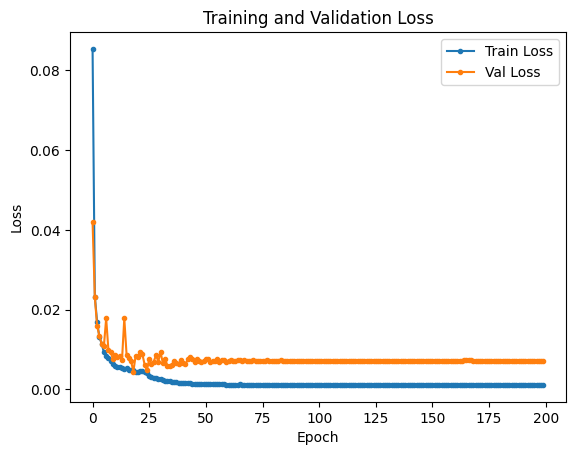

In [8]:
x = list(range(NUM_EPOCHS))
plt.plot(x, train_loss_list, label="Train Loss", marker=".")
plt.plot(x, val_loss_list, label="Val Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Step 4 - Save / load the model

After training, we need to save the models.

In [9]:
# Save the trained model to disk
torch.save(vgg16.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /home/ubuntu/Desktop/Ra/models/VGG_128_regression_decimal_1.pth


To read the saved data, we can run the following codes:

In [10]:
# # Load the trained model weights
# vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# vgg16.eval()
# print("Model loaded from", MODEL_PATH)

## Exceptional test

Let's see if the model works well.

Model loaded from /home/ubuntu/Desktop/Ra/models/VGG_128_regression_decimal_1.pth


      Real Labels  Predicted Labels      Diff      MAPE
0             2.4          2.172997 -0.227003  0.905416
1             2.7          2.336999 -0.363001  0.865555
2             4.1          3.500892 -0.599108  0.853876
3             3.7          3.239745 -0.460255  0.875607
4             4.1          3.642683 -0.457317  0.888459
...           ...               ...       ...       ...
1832          3.9          3.287492 -0.612508  0.842947
1833          1.6          1.520280 -0.079720  0.950175
1834          2.8          2.559901 -0.240099  0.914251
1835          2.6          2.445201 -0.154799  0.940462
1836          4.7          4.327193 -0.372807  0.920679

[1837 rows x 4 columns]
MAPE: 0.9124708935149086


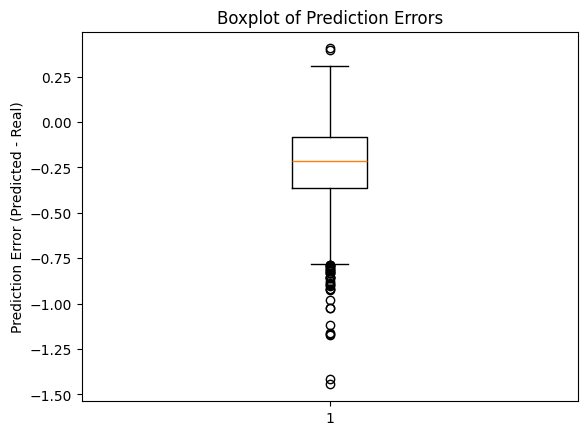

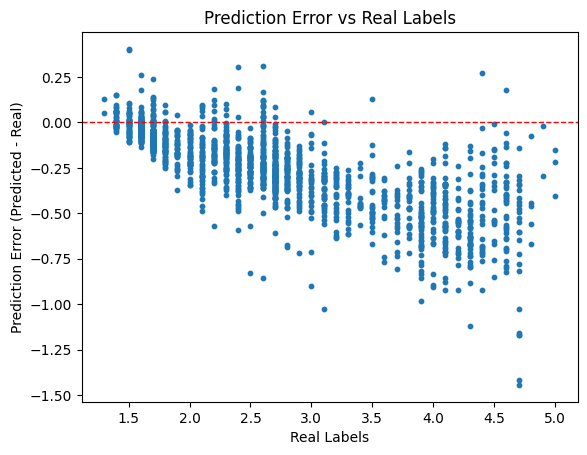

In [11]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = vgg16(images_val_tensor.to(device)).cpu().detach().numpy()

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()